# Machine Learning Project 
### Concept Bottleneck Models

#### Introduction
In recent years, neural networks have been successful in tasks that could require human-level intelligence, such as understanding and generating images or text, or controlling robots to follow instructions. However, the decision-making process of these networks is not often explainable, causing problems in user trust in sensitive or critical environments such as medicine, finance, or automation. This occurs because state-of-the-art models nowadays are trained end-to-end to go directly from an input $x$ to a desired target or output $y$, and we cannot easily interact with them using our high-level concepts.

Concept Bottleneck Models approach this problem with a simple idea, first predicting an intermediate set of human-specified concepts $c$ and then using this to predict the target $y$. In fact concepts can be represented by a unique neuron in the bottleneck layer ${f^c}$ of a model $f$. These models are trained on data points ($x$, $c$, $y$), where $x$ is the input annotated with concept $c$ and target $y$. During testing, they take an input $x$, predict concepts ${\hat{c}}$ and then use those to predict a target ${\hat{y}}$. The main achievement of CBM is that we can intervene on those concepts ${\hat{c}}$, editing them directly, and then propagating those changes to the final prediction ${\hat{y}}$. This intervention enhances the model-human interaction and the interpretability of the methods, and is what explainable Artificial Intelligencence XAI is trying to achieve.

In this work I tried to build end-to-end models that simulate what the authors did in [the original paper](http://proceedings.mlr.press/v119/koh20a/koh20a.pdf), obviously with a smaller capacity but anyway following the same concepts explained.

In [127]:
import torch 
from torch import nn
#from torch.nn import Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split #delete
#from torchvision.transforms import Lambda
import numpy as np
#from torchview import draw_graph
from torchinfo import summary
import pandas as pd
import matplotlib.pyplot as plt
import hiddenlayer as hl
from timeit import default_timer as timer
#import warnings
import random
import copy

print("You are using:")
!python --version
print(f"{torch.__version__=}")
print("MPS support=", torch.backends.mps.is_available())
if torch.backends.mps.is_available():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)


You are using:
Python 3.13.1
torch.__version__='2.6.0'
MPS support= True
Using device: mps


The dataset used is the Caltech-UCSD Birds-200-2011 (CUB) [here](https://www.florian-schroff.de/publications/CUB-200.pdf), which has $n$ = 11,788 bird images. Each image contains $k$ = 312 binary attributes, the task is to classify correctly the bird among the 200 possible species. This is not an easy datasets to work on, because an image $x_{i}$ labeled as $y_{m}$, can have different concepts $c$ with respect to an image $x_{j}$ with the same label $y_{m}$, leading to poor classification results.

In [128]:
import os 
import glob 
from PIL import Image

dataset_dir = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/images"

img_paths = glob.glob(os.path.join(dataset_dir, "*", "*.jpg"))
attribute4image_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/attributes/image_attribute_labels.txt"
attributes_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/attributes/attributes.txt"
class_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/classes.txt"
labels4image_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/image_class_labels.txt"
images_names = '/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/images.txt'

labels4image = pd.read_csv(labels4image_path, sep=' ', header=None)
classnames = pd.read_csv(class_path, sep=' ', header=None)

images_dict = {} #dictionary with image name and id

with open(images_names, 'r') as f:
    for line in f:
        img_ID, img_foldername = line.strip().split()
        img_name = img_foldername.split('/')[1]
        images_dict[img_name] = int(img_ID)
   

The class for loading the dataset has to be modified to include also the path of the directory and the ID of the images.

In [129]:
#modify imagefolder to include the IDs

class ImageFolderWithIDs(ImageFolder):
    def __init__(self, root, transform=None, id_map=images_dict):
        super().__init__(root, transform)
        self.id_map = id_map

    def __getitem__(self, index):

        img, label = super().__getitem__(index)

        img_path, _ = self.samples[index]
        img_filename = os.path.basename(img_path)

        image_id = self.id_map[img_filename]
        label += 1

        return img, label, image_id
       

In [130]:
#load the dataset
dataset = ImageFolderWithIDs(dataset_dir, transform=None, id_map=images_dict)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.ToTensor()
    ])
other_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

classes = sorted(np.unique(dataset.targets))
print(f"Number of Classes: {len(classes)}")
print(f"Dataset shape before splitting: {len(dataset)}")

label_count = {}

for _, label, img_id in dataset:
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1

print(label_count)

train_data, test_data, val_data = random_split(dataset, [0.75, 0.2, 0.05] )
print(f"Dataset shape after splitting: training={len(train_data)}, testing={len(test_data)}, validation={len(val_data)}")

train_data.dataset.transform = train_transform
val_data.dataset.transform = other_transform
test_data.dataset.transform = other_transform

Number of Classes: 200
Dataset shape before splitting: 11788
{1: 60, 2: 60, 3: 58, 4: 60, 5: 44, 6: 41, 7: 53, 8: 48, 9: 59, 10: 60, 11: 60, 12: 56, 13: 60, 14: 60, 15: 58, 16: 58, 17: 57, 18: 45, 19: 59, 20: 59, 21: 60, 22: 56, 23: 59, 24: 52, 25: 60, 26: 60, 27: 60, 28: 59, 29: 60, 30: 60, 31: 60, 32: 53, 33: 59, 34: 59, 35: 60, 36: 60, 37: 59, 38: 60, 39: 59, 40: 60, 41: 60, 42: 60, 43: 59, 44: 60, 45: 60, 46: 60, 47: 60, 48: 60, 49: 60, 50: 60, 51: 60, 52: 60, 53: 60, 54: 60, 55: 60, 56: 60, 57: 60, 58: 58, 59: 60, 60: 59, 61: 60, 62: 60, 63: 60, 64: 60, 65: 50, 66: 60, 67: 60, 68: 60, 69: 60, 70: 60, 71: 60, 72: 60, 73: 60, 74: 60, 75: 57, 76: 60, 77: 60, 78: 59, 79: 60, 80: 60, 81: 60, 82: 60, 83: 60, 84: 53, 85: 60, 86: 60, 87: 60, 88: 60, 89: 60, 90: 60, 91: 60, 92: 60, 93: 60, 94: 60, 95: 60, 96: 60, 97: 59, 98: 60, 99: 60, 100: 60, 101: 50, 102: 60, 103: 60, 104: 60, 105: 49, 106: 60, 107: 59, 108: 60, 109: 60, 110: 60, 111: 60, 112: 60, 113: 50, 114: 60, 115: 59, 116: 60, 11

In the cell below I loaded the attributes as tensor of zeros/ones of size [ 11788 * 312 ]

In [132]:
#load the attributes
attributes = torch.zeros(len(dataset), 312)

with open (attribute4image_path, 'r') as f:
    for line in f:
        value = line.strip().split()
        img_ID, att_ID, is_present = value[:3]
        attributes[int(img_ID)-1, int(att_ID)-1] = int(is_present)



In [6]:
#Create the dataloaders for each of them, batch size is set
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

A dictionary containing as keys the name of the attributes from 'attributes.txt", and as values the indexes of the attributes

In [ ]:
#define a concept group dictionary
concept_groups = {}

with open(attributes_path, 'r') as f:
    for line in f:
        attrib_ID, attribute_name = line.strip().split()
        attribute_real = attribute_name.split(':')[0]
        if attribute_real not in concept_groups.keys():
            concept_groups[attribute_real] = []
        concept_groups[attribute_real].append(int(attrib_ID))


Image shape: 32, label: 141, img_id: 8246


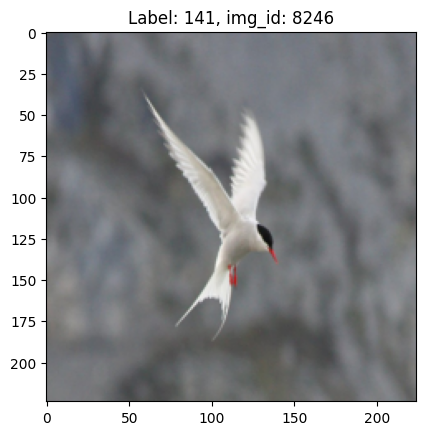

In [8]:
for img, label, img_id in train_loader:
    print(f"Image shape: {img.shape[0]}, label: {label[0]}, img_id: {img_id[0]}")

    image = img[0].numpy().transpose(1, 2, 0)
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.title(f"Label: {label[0]}, img_id: {img_id[0]}")
    plt.show()
    break

In [9]:
from torchvision.models import resnet50, ResNet50_Weights

In [133]:
RESNET = resnet50(pretrained=True)
summary(RESNET, (32, 3, 224, 224), device=device)


/Users/niccolozenaro/Università/Machine Learning/MachineLearningProject/myenv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/niccolozenaro/Università/Machine Learning/MachineLearningProject/myenv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

To get the concepts the model used is *RESNET50*. Only the last fully-connected layer has been fine-tuned, so I substituted it in order to obtain the  312 binary predictions of the concepts.

In [11]:
#fine-tuning the model

class ResNet50AttributesTuned(nn.Module):
    def __init__(self, num_attributes, weights=ResNet50_Weights.IMAGENET1K_V1, freeze_backbone=True):
        super(ResNet50AttributesTuned, self).__init__()

        self.resnet = resnet50(weights=weights)

    #finetune only the last fc layer 
        if freeze_backbone:
            for name, param in self.resnet.named_parameters():
                #if "layer4" in name or "fc" in name:  <- could be interesting to finetune also the last conv layer
                if "fc" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_attributes)

    def forward(self, x):
        return self.resnet(x)       

In [12]:
#training function
def trainFineTune (model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    
    loss_train, loss_val = [], []
    acc_train, acc_val = [], []
    history1 = hl.History()
    canvas1 = hl.Canvas()

    for epoch in range(num_epochs):
        model.train()
        tot_acc_train, tot_count_train, n_train_batches, tot_loss_train = 0, 0, 0, 0

        for img, label, img_ID in train_loader:
            img = img.to(device)
            attribute = attributes[img_ID-1].to(device)
            optimizer.zero_grad()
            prediction = model(img)
            loss = criterion(prediction, attribute)

            tot_loss_train += loss.item()
            loss.backward()
            optimizer.step()

            tot_acc_train += ((prediction > 0.5).float() == attribute).sum().item()
            tot_count_train += attribute.numel()
            n_train_batches += 1

        avg_loss_train = tot_loss_train / n_train_batches
        loss_train.append(avg_loss_train)
        accuracy_train = (tot_acc_train / tot_count_train) * 100
        acc_train.append(accuracy_train)

        tot_acc_val, tot_count_val, n_val_batches, tot_loss_val = 0, 0, 0, 0

        with torch.no_grad():
            model.eval()
            for img, label, img_ID in val_loader:
                img = img.to(device)
                attribute = attributes[img_ID-1].to(device)
                prediction = model(img)
                loss = criterion(prediction, attribute)

                tot_loss_val += loss.item()

                tot_acc_val += ((prediction > 0.5).float() == attribute).sum().item()
                tot_count_val += attribute.numel()
                n_val_batches += 1
        
        avg_loss_val = tot_loss_val / n_val_batches
        loss_val.append(avg_loss_val)
        accuracy_val = (tot_acc_val / tot_count_val) * 100
        acc_val.append(accuracy_val)

        if epoch % 1 == 0:
            history1.log(epoch, train_loss = avg_loss_train, train_accuracy = accuracy_train, val_loss = avg_loss_val, val_accuracy = accuracy_val)
            with canvas1:
                canvas1.draw_plot([history1["train_loss"], history1["val_loss"]], labels=['Training Loss', 'Validation Loss'])
                canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]], labels=['Training Accuracy', 'Validation Accuracy'])

    return loss_train, acc_train, loss_val, acc_val

#if you want to plot again
def plot_learning_acc_loss(loss_train, acc_train, loss_val, acc_val):
    
    plt.figure(figsize=(10, 12))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(len(acc_train)), acc_train, label="Training Accuracy")
    plt.plot(range(len(acc_val)), acc_val, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(len(loss_train)), loss_train, label="Training Loss")
    plt.plot(range(len(loss_val)), loss_val, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')

    plt.show()


In [58]:
num_epochs = 15
lr = 1e-4

ResNetmodel = ResNet50AttributesTuned(num_attributes=312, weights=ResNet50_Weights.IMAGENET1K_V1, freeze_backbone=True)

#pos_weight for BCEWithLogitsLoss as defined by the original paper because of the imbalanced attributes
pos_weight = torch.tensor([9.0] * 312).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(ResNetmodel.resnet.fc.parameters(), lr=lr, weight_decay=5e-4)

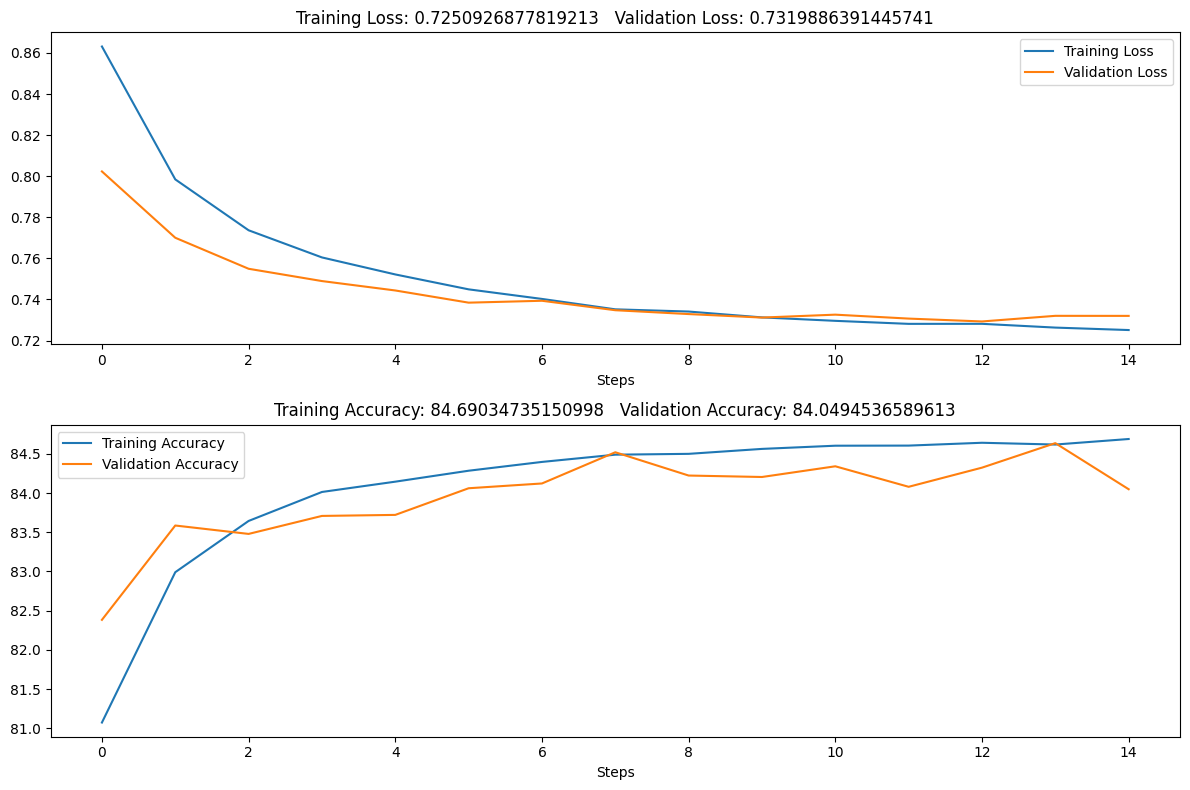

Training took 2286.44 seconds


In [27]:
start = timer()

torch.mps.empty_cache()
loss_train, acc_train, loss_val, acc_val = trainFineTune(ResNetmodel, train_loader, val_loader, criterion, optimizer, num_epochs, device)

end = timer()

print(f"Training took {end-start:.2f} seconds")

In [14]:
def testFineTuned (model, dataloader_test = test_loader):
    model.eval()

    tot_acc, tot_count, n_batches, tot_loss = 0, 0, 0, 0
    for img, label, img_ID in dataloader_test:
        img = img.to(device)
        attribute = attributes[img_ID-1].to(device)
        prediction = model(img)
        tot_loss += criterion(prediction, attribute)
        tot_acc += ((prediction > 0.5).float() == attribute).sum().item()
        tot_count += attribute.numel()
        n_batches += 1

    accuracy_test = (tot_acc / tot_count) * 100
    loss_test = tot_loss / n_batches

    print(f"Test Loss: {loss_test:.4f}, Test Accuracy: {accuracy_test:.4f}")

In [15]:
#torch.mps.empty_cache()
#model = ResNet50AttributesTuned(num_attributes=312, weights=ResNet50_Weights.IMAGENET1K_V1, freeze_backbone=True)
ResNetmodel.load_state_dict(torch.load("/Users/niccolozenaro/Università/Machine Learning/FinetunedResnet.pth"))
ResNetmodel.to(device)
testFineTuned(ResNetmodel)

Test Loss: 0.7305, Test Accuracy: 84.4018


In [16]:
torch.mps.empty_cache()

In [32]:
#torch.save(model.state_dict(), "/Users/niccolozenaro/Università/Machine Learning/FinetunedResnet.pth")

The Multilayer Perceptron has been used for the final classification. It has 3 hidden layers, but with the parameter 'expand_dim' we can modify the MLP as we want.

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes, expand_dim=[]):
        super(MLP, self).__init__()
        
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(0.3)
        self.batchnorm = nn.ModuleList()

        if len(expand_dim) == 0:
            self.layers.append(nn.Linear(input_dim, num_classes))
        else:
            for layer_idx in range(len(expand_dim)):
                if layer_idx == 0:
                    self.layers.append(nn.Linear(input_dim, expand_dim[0]))
                else:
                    self.layers.append(nn.Linear(expand_dim[layer_idx-1], expand_dim[layer_idx]))
                
                self.batchnorm.append(nn.BatchNorm1d(expand_dim[layer_idx]))
                    
            self.layers.append(nn.Linear(expand_dim[-1], num_classes))

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x):
        if len(self.layers) == 1:
            return self.layers[0](x)
        else:
            for i, layer in enumerate(self.layers[:-1]):
                x = torch.relu(layer(x))
                x = self.batchnorm[i](x)
                x = self.dropout(x)
            return self.layers[-1](x)

In [42]:
def train(model, optimizer, criterion, dataloader_train, dataloader_val, num_epochs, device, early_stopping, tolerance):
    model.to(device)

    loss_train, loss_val = [], []
    acc_train, acc_val = [], []
    history1 = hl.History()
    canvas1 = hl.Canvas()

    best_val_loss = float('inf')
    best_model = None
    num_epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        tot_acc_train, tot_count_train, n_train_batches, tot_loss_train = 0, 0, 0, 0
        for _, label, img_id in dataloader_train:
            attribute = attributes[img_id-1].to(device)
            label = label.to(device)
            logits = model(attribute)
            loss = criterion(logits, label-1)
            optimizer.zero_grad()
            tot_loss_train += loss
            
            loss.backward()
            optimizer.step()

            pred_label = torch.argmax(logits, dim=1)
            accuracy = (pred_label == label-1).sum().item()

            tot_acc_train += accuracy
            tot_count_train += label.size(0)
            n_train_batches += 1 

        avg_loss_train = tot_loss_train / n_train_batches
        loss_train.append(avg_loss_train)
        accuracy_train = (tot_acc_train / tot_count_train) * 100
        acc_train.append(accuracy_train)

        tot_acc_val, tot_count_val, n_val_batches, tot_loss_val = 0, 0, 0, 0

        with torch.no_grad():
            model.eval()

            for _, label, img_id in dataloader_val:
                attribute = attributes[img_id-1].to(device)
                label = label.to(device)
                logits = model(attribute)
                loss = criterion(logits, label-1)

                tot_loss_val += loss

                pred_label = torch.argmax(logits, dim=1)
                accuracy = (pred_label == label-1).sum().item()

                tot_acc_val += accuracy
                tot_count_val += label.size(0)
                n_val_batches += 1

            avg_loss_val = tot_loss_val / n_val_batches
            loss_val.append(avg_loss_val)
            accuracy_val = (tot_acc_val / tot_count_val) * 100
            acc_val.append(accuracy_val)

            if epoch % 1 == 0:
                history1.log(epoch, train_loss = avg_loss_train, train_accuracy = accuracy_train, val_loss = avg_loss_val, val_accuracy = accuracy_val)
            with canvas1:
                canvas1.draw_plot([history1["train_loss"], history1["val_loss"]], labels=['Training Loss', 'Validation Loss'])
                canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]], labels=['Training Accuracy', 'Validation Accuracy'])

            if avg_loss_val < best_val_loss and (avg_loss_train - avg_loss_val) > tolerance:
                best_val_loss = avg_loss_val
                best_model = copy.deepcopy(model)
                num_epochs_no_improve = 0
            else:
                num_epochs_no_improve += 1

            if num_epochs_no_improve >= early_stopping:
                print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                break
                

    return loss_train, acc_train, loss_val, acc_val, best_model

In [40]:
num_epochs = 30
lr = 1e-3

MLPmodel = MLP(input_dim=312, num_classes=200, expand_dim=[400, 500, 300])
MLPmodel.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(MLPmodel.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4, nesterov=True)

In [ ]:
start = timer()

torch.mps.empty_cache()
loss_train, acc_train, loss_val, acc_val, best_model = train(MLPmodel, optimizer, criterion, train_loader, val_loader, num_epochs, device, early_stopping=10, tolerance=0.1)

end = timer()

print(f"Training took {end-start:.2f} seconds")

torch.save(best_model.state_dict(), "/Users/niccolozenaro/Università/Machine Learning/best_model.pth")

In [38]:
def testMLP(model, dataloader_test = test_loader):
    model.eval()
    model.to(device)
    
    tot_acc, tot_count, n_batches, tot_loss = 0, 0, 0, 0
    for _, label, img_ID in dataloader_test:
        attribute = attributes[img_ID-1].to(device)
        label = label.to(device)
        logits = model(attribute)
        tot_loss += criterion(logits, label-1)
        pred_label = torch.argmax(logits, dim=1)
        tot_acc += (pred_label == label-1).sum().item()
        tot_count += label.size(0)
        n_batches += 1

    accuracy_test = (tot_acc / tot_count) * 100
    loss_test = tot_loss / n_batches

    print(f"Test Loss: {loss_test:.4f}, Test Accuracy: {accuracy_test:.4f}")

In [39]:
MLPmodel.load_state_dict(torch.load("/Users/niccolozenaro/Università/Machine Learning/best_model.pth"))
MLPmodel.to(device)
testMLP(MLPmodel)

Test Loss: 2.5412, Test Accuracy: 40.2630


In [78]:
torch.mps.empty_cache()

The joint bottleneck minimizes the weighted sum of the losses of the two models $\hat{g}$ and $\hat{f}$, with the CNNLoss weighted with a factor lambda > 0.

In [112]:
def CBMtrain(cnnmodel, mlpmodel, cnnoptimizer, mlpoptimizer, cnncriterion, mlpcriterion, train_loader, val_loader, num_epochs, device, early_stopping, tolerance, lambda_val):
    cnnmodel.to(device)
    mlpmodel.to(device)

    loss_train, acc_train, loss_val, acc_val = [], [], [], []

    #add early stopping
    best_val_loss = float('inf')
    num_epochs_no_improve = 0

    history1 = hl.History()
    canvas1 = hl.Canvas()

    for epoch in range(num_epochs):
        cnnmodel.train()
        mlpmodel.train()

        tot_loss_train, tot_acc_train, n_batches_train, count_train = 0, 0, 0, 0

        for img, label, img_ID in train_loader:
            img, label = img.to(device), label.to(device).long()
            real_attribute = attributes[img_ID-1].to(device)

            cnnoptimizer.zero_grad()
            mlpoptimizer.zero_grad()

            logits = cnnmodel(img)

            classes = mlpmodel(logits)
            #print(f"Classes requires grad: {classes.requires_grad}")
            #print(f"Labels do not require grad {label.requires_grad}")

            #compute loss
            concept_loss = cnncriterion(logits, real_attribute)
            classif_loss = mlpcriterion(classes, label-1)
            tot_loss = lambda_val * concept_loss + classif_loss

            tot_loss.backward()
            mlpoptimizer.step()
            cnnoptimizer.step()

            pred_label = torch.argmax(classes, dim=1)
            accuracy = (pred_label == label-1).sum().item()

            tot_loss_train += tot_loss
            tot_acc_train += accuracy
            count_train += label.size(0)
            n_batches_train += 1

        avg_train_loss = tot_loss_train / n_batches_train
        accuracy_train = (tot_acc_train / count_train) * 100
        loss_train.append(avg_train_loss)
        acc_train.append(accuracy_train)

        cnnmodel.eval()
        mlpmodel.eval()

        tot_loss_val, tot_acc_val, n_batches_val, count_val = 0, 0, 0, 0

        with torch.no_grad():

            cnnmodel.eval()
            mlpmodel.eval()

            for img, label, img_id in val_loader:
                img, label = img.to(device), label.to(device)
                real_attribute = attributes[img_id-1].to(device)

                #cnnoptimizer.zero_grad()
                #mlpoptimizer.zero_grad()

                logits = cnnmodel(img)
                classes = mlpmodel(logits)
                #print(f"VAL Classes requires grad: {classes.requires_grad}")
                #print(f"VAL Labels do not require grad {label.requires_grad}")

                #compute loss
                concept_loss = cnncriterion(logits, real_attribute)
                classif_loss = mlpcriterion(classes, label-1)
                tot_loss = lambda_val * concept_loss + classif_loss

                #tot_loss_val.backward()
                #optimizer.step()

                pred_label = torch.argmax(classes, dim=1)
                accuracy = (pred_label == label-1).sum().item()

                tot_loss_val += tot_loss
                tot_acc_val += accuracy
                n_batches_val += 1
                count_val += label.size(0)

            avg_loss_val = tot_loss_val / n_batches_val
            avg_acc_val = (tot_acc_val / count_val) * 100
            loss_val.append(avg_loss_val)
            acc_val.append(avg_acc_val)

            if epoch % 1 == 0:
                history1.log(epoch, train_loss = avg_train_loss, train_accuracy = accuracy_train, val_loss = avg_loss_val, val_accuracy = avg_acc_val)
            with canvas1:
                canvas1.draw_plot([history1["train_loss"], history1["val_loss"]], labels=['Training Loss', 'Validation Loss'])
                canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]], labels=['Training Accuracy', 'Validation Accuracy'])

            if avg_loss_val < best_val_loss and (avg_train_loss - avg_loss_val) > tolerance:
                best_val_loss = avg_loss_val
                num_epochs_no_improve = 0
            else:
                num_epochs_no_improve += 1

            if num_epochs_no_improve >= early_stopping:
                print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                break
                

            


In [115]:
#load the 2 models redefined above
lr = 1e-3
num_epochs = 20

cnnmodel = ResNet50AttributesTuned(num_attributes=312, weights=ResNet50_Weights.IMAGENET1K_V1, freeze_backbone=True)
cnnoptimizer = torch.optim.Adam(cnnmodel.resnet.fc.parameters(), lr=lr, weight_decay=5e-4)
pos_weight = torch.tensor([9.0]*312).to(device)
cnn_loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

mlpmodel = MLP(input_dim=312, num_classes=200, expand_dim=[400, 500, 300])
mlpoptimizer = torch.optim.SGD(mlpmodel.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=5e-4)
mlp_loss = torch.nn.CrossEntropyLoss()

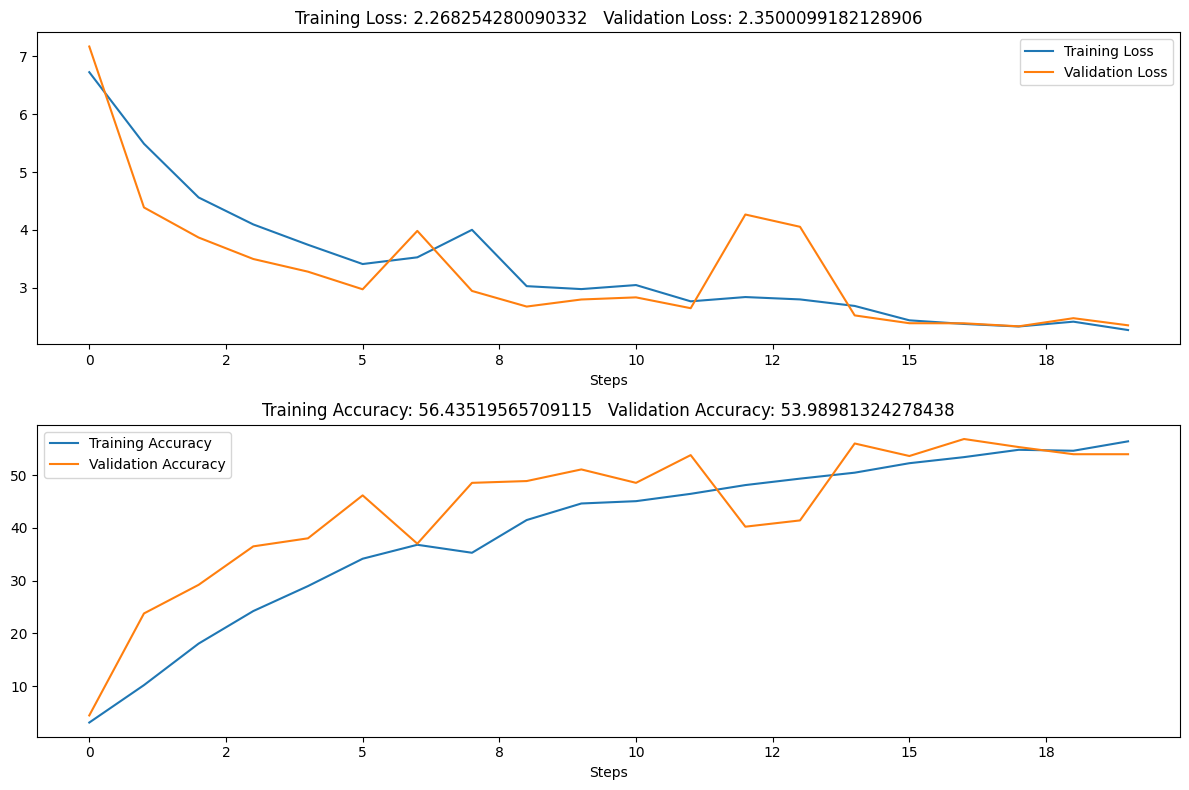

Early stopping at epoch 19. Best validation loss: 2.5213
Training took 2369.95 seconds


In [116]:
start = timer()

torch.mps.empty_cache()
CBMtrain(cnnmodel=cnnmodel, cnncriterion=cnn_loss, cnnoptimizer=cnnoptimizer,
         mlpmodel=mlpmodel, mlpcriterion=mlp_loss, mlpoptimizer=mlpoptimizer,
         num_epochs=num_epochs, train_loader=train_loader, val_loader=val_loader,
         early_stopping=5, tolerance=0.1, lambda_val=0.8, device=device)

end = timer()

print(f"Training took {end - start:.2f} seconds")

In [123]:
#testing procedure

def testCBM (cnnmodel, mlpmodel, cnn_criterion, mlp_criterion, lambda_val, intervention, level, test_loader=test_loader):
    cnnmodel.eval()
    mlpmodel.eval()

    tot_acc, tot_count, n_batches, tot_loss = 0, 0, 0, 0

    if intervention:
        random_keys = random.sample(list(concept_groups.keys()), level)

    for img, label, img_id in test_loader:
        img, label = img.to(device), label.to(device)
        attribute = attributes[img_id].to(device)

        pred_att = cnnmodel(img)

        if intervention and level:
            for key in random_keys:
                values = concept_groups[key]
                for value in values:
                    pred_att[:, value] = attributes[img_id, value]

        pred_output = mlpmodel(pred_att)

        att_loss = cnn_criterion(pred_att, attribute)
        output_loss = mlp_criterion(pred_output, label-1)
        loss = lambda_val * att_loss + output_loss
        tot_loss += loss

        pred_label = torch.argmax(pred_output, dim=1)
        tot_acc += (pred_label == label-1).sum().item()
        tot_count += label.size(0)
        n_batches += 1
    
    accuracy_test = (tot_acc / tot_count) * 100
    loss_test = tot_loss / n_batches

    print(f"Test Loss: {loss_test:.4f}, Test Accuracy: {accuracy_test:.4f}")
        

In [ ]:
cnn_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
mlp_criterion = torch.nn.CrossEntropyLoss()
testCBM(cnnmodel=cnnmodel, mlpmodel=mlpmodel, cnn_criterion=cnn_criterion, mlp_criterion=mlp_criterion, lambda_val=0.8, test_loader=test_loader, intervention=False, level=3)

Test Loss: 2.4388, Test Accuracy: 54.6457


In [120]:
torch.save(cnnmodel.state_dict(), "/Users/niccolozenaro/Università/Machine Learning/JointCNN.pth")
torch.save(mlpmodel.state_dict(), "/Users/niccolozenaro/Università/Machine Learning/JointMLP.pth")

The Sequential bottleneck first learns the concepts of model $\hat{g}$ independently. Then, it uses the concept prediction $\hat{c}$ to learn the labels $y$.

In [81]:
def trainSequentialCBM(mlpmodel, cnnmodel, optimizer, criterion, dataloader_train, dataloader_val, num_epochs, device, early_stopping, tolerance):
    mlpmodel.to(device)
    cnnmodel.to(device)

    loss_train, loss_val = [], []
    acc_train, acc_val = [], []
    history1 = hl.History()
    canvas1 = hl.Canvas()

    best_val_loss = float('inf')
    best_model = None
    num_epochs_no_improve = 0

    for epoch in range(num_epochs):
        mlpmodel.train()
        tot_acc_train, tot_count_train, n_train_batches, tot_loss_train = 0, 0, 0, 0
        for img, label, img_id in dataloader_train:

            img, label = img.to(device), label.to(device)

            with torch.no_grad():
                output = cnnmodel(img)
                #since the model does not apply sigmoid activation
                attribute = torch.sigmoid(output)

            logits = mlpmodel(attribute)
            loss = criterion(logits, label-1)
            optimizer.zero_grad()
            tot_loss_train += loss
            
            loss.backward()
            optimizer.step()

            pred_label = torch.argmax(logits, dim=1)
            accuracy = (pred_label == label-1).sum().item()

            tot_acc_train += accuracy
            tot_count_train += label.size(0)
            n_train_batches += 1 

        avg_loss_train = tot_loss_train / n_train_batches
        loss_train.append(avg_loss_train)
        accuracy_train = (tot_acc_train / tot_count_train) * 100
        acc_train.append(accuracy_train)

        tot_acc_val, tot_count_val, n_val_batches, tot_loss_val = 0, 0, 0, 0

        with torch.no_grad():
            mlpmodel.eval()

            for img, label, img_id in dataloader_val:
                #attribute = attributes[img_id-1].to(device)
                img, label = img.to(device), label.to(device)
                out = cnnmodel(img)
                attribute = torch.sigmoid(out)
                logits = mlpmodel(attribute)
                
                loss = criterion(logits, label-1)
                tot_loss_val += loss

                pred_label = torch.argmax(logits, dim=1)
                accuracy = (pred_label == label-1).sum().item()

                tot_acc_val += accuracy
                tot_count_val += label.size(0)
                n_val_batches += 1

            avg_loss_val = tot_loss_val / n_val_batches
            loss_val.append(avg_loss_val)
            accuracy_val = (tot_acc_val / tot_count_val) * 100
            acc_val.append(accuracy_val)

            if epoch % 1 == 0:
                history1.log(epoch, train_loss = avg_loss_train, train_accuracy = accuracy_train, val_loss = avg_loss_val, val_accuracy = accuracy_val)
            with canvas1:
                canvas1.draw_plot([history1["train_loss"], history1["val_loss"]], labels=['Training Loss', 'Validation Loss'])
                canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]], labels=['Training Accuracy', 'Validation Accuracy'])

            if avg_loss_val < best_val_loss and (avg_loss_train - avg_loss_val) > tolerance:
                best_val_loss = avg_loss_val
                best_model = copy.deepcopy(mlpmodel)
                num_epochs_no_improve = 0
            else:
                num_epochs_no_improve += 1

            if num_epochs_no_improve >= early_stopping:
                print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                break
                

    return loss_train, acc_train, loss_val, acc_val, best_model

In [82]:
torch.mps.empty_cache()

lr = 1e-3

cnnmodel = ResNet50AttributesTuned(num_attributes=312, weights=ResNet50_Weights.IMAGENET1K_V1, freeze_backbone=True)
cnnmodel.load_state_dict(torch.load("/Users/niccolozenaro/Università/Machine Learning/FinetunedResnet.pth"))
cnnmodel.to(device)

mlpmodel = MLP(input_dim=312, num_classes=200, expand_dim=[400, 500, 300])
mlpmodel.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlpmodel.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4, nesterov=True)

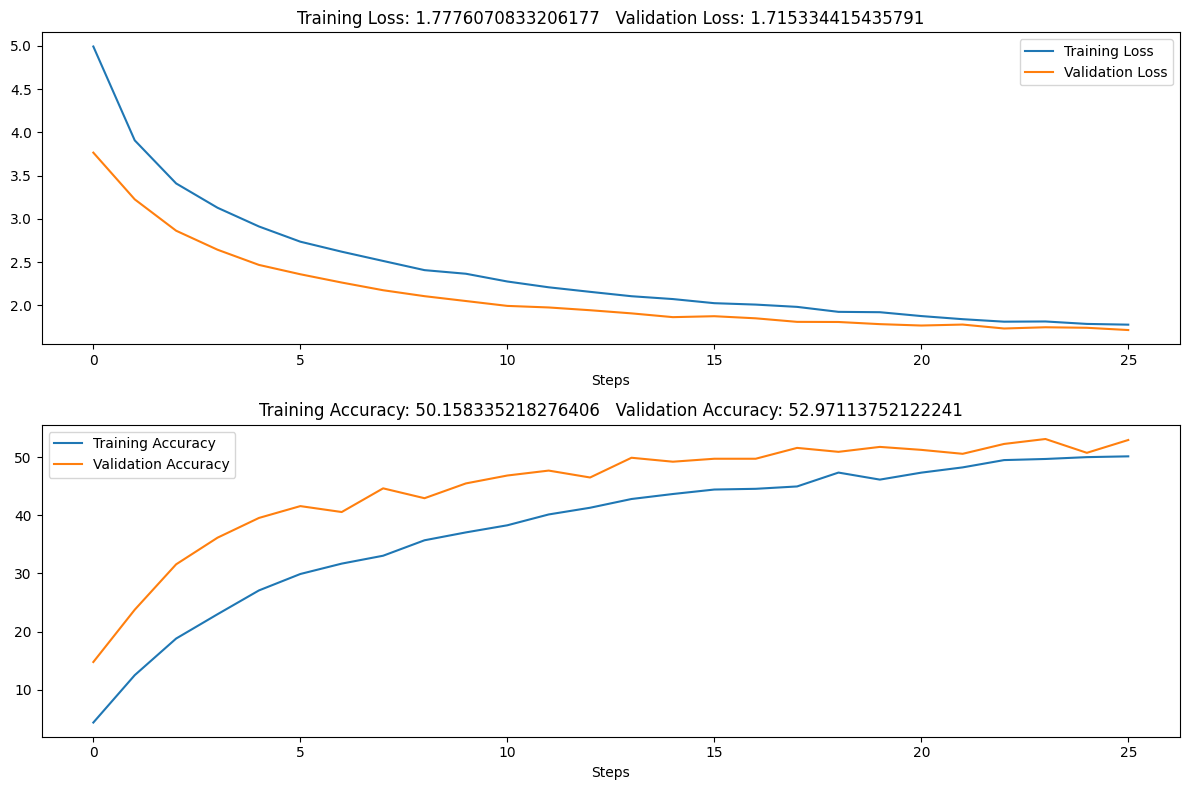

Early stopping at epoch 25. Best validation loss: 1.7675
Training took 3127.74 seconds


In [ ]:
start = timer()

loss_train, acc_train, loss_val, acc_train, best_model = trainSequentialCBM(mlpmodel, cnnmodel, optimizer, criterion, dataloader_train=train_loader, dataloader_val=val_loader, device=device, num_epochs=num_epochs, early_stopping=5, tolerance=0.1)

end = timer()

print(f"Training took {end-start:.2f} seconds")


In [102]:
def testSequential (mlpmodel, cnnmodel, test_loader, intervention, level):
    mlpmodel.to(device)
    cnnmodel.to(device)

    mlpmodel.eval()
    cnnmodel.eval()

    tot_acc, tot_count, n_batches, tot_loss = 0, 0, 0, 0

    if intervention:
        random_keys = random.sample(list(concept_groups.keys()), level)

    for img, label, img_id in test_loader:
        img, label = img.to(device), label.to(device)

        attribute = cnnmodel(img)
        input = torch.sigmoid(attribute)

        if intervention and level:
            for key in random_keys:
                values = concept_groups[key]
                for value in values:
                    input[:, value] = attributes[img_id, value]

        logits = mlpmodel(input)

        tot_loss += criterion(logits, label-1)
        pred_label = torch.argmax(logits, dim=1)
        tot_acc += (pred_label == label-1).sum().item()
        tot_count += label.size(0)
        n_batches += 1

    acc_test = (tot_acc / tot_count) * 100
    loss_test = tot_loss / n_batches

    print(f"Test Loss: {loss_test:.4f}, Test Accuracy: {acc_test:.4f}")



In [87]:
torch.save(best_model.state_dict(), "/Users/niccolozenaro/Università/Machine Learning/SequentialModel.pth")

In [110]:
testSequential(best_model, cnnmodel, test_loader, intervention=False, level=1)

Test Loss: 1.7705, Test Accuracy: 51.7183


The Independent bottleneck learns the model $f$ and $g$ independently, but at test time it still uses the concept prediction of ${\hat{g}}$ as input for the prediction of $y$

In [98]:
def testIndependent(cnnmodel, mlpmodel, test_loader, intervention, level):
    cnnmodel.to(device)
    mlpmodel.to(device)

    cnnmodel.eval()
    mlpmodel.eval()

    tot_loss, tot_acc, n_batches, tot_count = 0, 0, 0, 0

    if intervention:
        random_keys = random.sample(list(concept_groups.keys()), level)

    for img, label, img_id in test_loader:

        img, label = img.to(device), label.to(device)

        output = cnnmodel(img)
        pred_att = torch.sigmoid(output)


        if intervention and level:
            for key in random_keys:
                values = concept_groups[key]
                for value in values:
                    pred_att[:, value] = attributes[img_id, value]

        logit = mlpmodel(pred_att)

        tot_loss += criterion(logit, label-1)

        pred_label = torch.argmax(logit, dim=1)
        tot_acc += (pred_label == label-1).sum().item()
        tot_count += label.size(0)
        n_batches += 1

    acc_test = (tot_acc / tot_count) * 100
    loss_test = tot_loss / n_batches

    print(f"Test Loss: {loss_test:.4f}, Accuracy Test: {acc_test:.4f}")

        

In [101]:
torch.mps.empty_cache()

mlpmodel = MLP(input_dim=312, num_classes=200, expand_dim=[400, 500, 300])
mlpmodel.load_state_dict(torch.load("/Users/niccolozenaro/Università/Machine Learning/best_model.pth"))
cnnmodel = ResNet50AttributesTuned(num_attributes=312, weights=ResNet50_Weights.IMAGENET1K_V1, freeze_backbone=True)
cnnmodel.load_state_dict(torch.load("/Users/niccolozenaro/Università/Machine Learning/FinetunedResnet.pth"))

testIndependent(cnnmodel, mlpmodel, test_loader, intervention=False, level=5)

Test Loss: 3.7750, Accuracy Test: 11.8371


In every Test Loop, we can use the intervention or not. Testing with intervention means 'correcting' some attributes, as an expert can do, using the real attributes. In the loop the concepts are generated at random, but the number of concepts is set with the variable '*level*'.

As we can see, the best CBM is the **Joint**, but also the **Sequential** is giving good results. On the other hand, the **Independent** has bad values both for loss and accuracy.
With intervention, the **Independent** sees some improvements in accuracy, while the other two **Joint** and **Sequential** have no significant improvements, with the **Sequential** that gives worst results with increasing levels of intervention. 

For the development of this project, I used materials on blogs and forums, like the PyTorch [site](https://pytorch.org), the PyTorch [forum](https://discuss.pytorch.org), StackOverflow [forum](https://stackoverflow.com/questions/75979632/pytorchs-nn-bcewithlogitsloss-behaves-totaly-differently-than-nn-bceloss), Medium [forum](https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e), but also code assistants like GitHub-copilot or ChatGPT-4o for correcting issues and errors.